This notebook produces a train/val/test stratifying according to zygocity and gender. It also takes only subjects with Flanker values below and above 25 and 75-percentile. 

In [1]:
import glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns

pd.options.display.max_rows = 20

# Gets subjects treated with morphologist with relevant columns

In [2]:
participants_file = "/neurospin/dico/data/bv_databases/human/not_labeled/hcp/participants.csv"
participants_unrestricted = pd.read_csv(participants_file)
participants_unrestricted = participants_unrestricted[['Subject', "Gender", "Flanker_AgeAdj"]]
participants_unrestricted.head()


,Subject,Gender,Flanker_AgeAdj
0,100004,M,111.01
1,100206,M,116.55
2,100307,F,101.90
3,100408,M,113.51
4,100610,M,114.18


In [3]:
len(participants_unrestricted)

1206

In [4]:
participants_file = "~/RESTRICTED_jchavas_1_18_2022_3_17_51.csv"
participants = pd.read_csv(participants_file)
len(participants)

1206

In [5]:
participants = participants[['Subject', 'ZygosityGT', 'Family_ID']]
participants.head()

,Subject,ZygosityGT,Family_ID
0,100004,,52259_82122
1,100206,,56037_85858
2,100307,MZ,51488_81352
3,100408,MZ,51730_81594
4,100610,DZ,52813_82634


In [6]:
participants = pd.merge(participants_unrestricted, participants)
participants.head()

,Subject,Gender,Flanker_AgeAdj,ZygosityGT,Family_ID
0,100004,M,111.01,,52259_82122
1,100206,M,116.55,,56037_85858
2,100307,F,101.90,MZ,51488_81352
3,100408,M,113.51,MZ,51730_81594
4,100610,M,114.18,DZ,52813_82634


In [7]:
participants.loc[(participants['ZygosityGT']== " "), 'ZygosityGT'] = 'NotTwin'  
participants['Subject'] = participants['Subject'].astype('string')


In [8]:
print(participants.dtypes)
participants.head()

Subject           string[python]
Gender                    object
Flanker_AgeAdj           float64
ZygosityGT                object
Family_ID                 object
dtype: object


,Subject,Gender,Flanker_AgeAdj,ZygosityGT,Family_ID
0,100004,M,111.01,NotTwin,52259_82122
1,100206,M,116.55,NotTwin,56037_85858
2,100307,F,101.90,MZ,51488_81352
3,100408,M,113.51,MZ,51730_81594
4,100610,M,114.18,DZ,52813_82634


In [9]:
treated_subjects = glob.glob("/neurospin/dico/data/bv_databases/human/not_labeled/hcp/hcp/*[!.minf]")
treated_subjects = [x.split('/')[-1] for x in treated_subjects]
treated_subjects = [x for x in treated_subjects if 'database' not in x]
print(treated_subjects[:5])
len(treated_subjects)

['210112', '579665', '922854', '517239', '329440']


1114

In [10]:
participants.dtypes

Subject           string[python]
Gender                    object
Flanker_AgeAdj           float64
ZygosityGT                object
Family_ID                 object
dtype: object

In [11]:
participants = participants[participants['Subject'].isin(treated_subjects)]

In [12]:
len(participants)

1113

In [13]:
set(treated_subjects) - set(participants['Subject'])

{'142626'}

# Separates according to gender and zygocity

In [14]:
set(participants['ZygosityGT'].tolist())

{'DZ', 'MZ', 'NotTwin'}

In [15]:
def create_subset(df, gender, zygosityGT):
    """Creates a subset of participants.
    
    The subset corresponds to the values of column gender and zygosityGT"""
    subset = df[(df['Gender']==gender) & (df['ZygosityGT']==zygosityGT)]
    subset = subset.groupby(by='Family_ID', as_index=False).apply(lambda x: x)

    return subset

In [16]:
M_MZ = create_subset(participants, 'M', 'MZ')
F_MZ = create_subset(participants, 'F', 'MZ')
M_DZ = create_subset(participants, 'M', 'DZ')
F_DZ = create_subset(participants, 'F', 'DZ')
M_NotTwin = create_subset(participants, 'M', 'NotTwin')
F_NotTwin = create_subset(participants, 'F', 'NotTwin')
M_MZ.head()

Subject Gender  Flanker_AgeAdj ZygosityGT    Family_ID
0 632   233326      M          114.95         MZ  51698_81562
  719   352738      M          120.15         MZ  51698_81562
1 253   146432      M          108.16         MZ  51702_81566
  1077  818859      M           96.24         MZ  51702_81566
2 155   128935      M          108.56         MZ  51707_81571

In [17]:
F_MZ[F_MZ.Family_ID=="51106_80975"]

,,Subject,Gender,Flanker_AgeAdj,ZygosityGT,Family_ID
0,130,123723,F,99.98,MZ,51106_80975


# Stratify

In [18]:
partition = [0.7,0.15,0.15]

In [19]:
def get_train(df, partition):
    df = df.copy(deep=True)
    upper = int(len(df)*partition[0]/2)*2
    return df[0:upper]

def get_val(df, partition):
    df = df.copy(deep=True)
    lower = int(len(df)*partition[0]/2)*2
    upper = int(len(df)*(partition[0]+partition[1])/2)*2
    return df[lower:upper]

def get_test(df, partition):
    df = df.copy(deep=True)
    lower = int(len(df)*(partition[0]+partition[1])/2)*2
    return df[lower:]


In [20]:
participants.dtypes

Subject           string[python]
Gender                    object
Flanker_AgeAdj           float64
ZygosityGT                object
Family_ID                 object
dtype: object

In [21]:
def partition_subset(df, partition):
    train = get_train(df, partition)
    val = get_val(df, partition)
    test = get_test(df, partition)
    print(f"lengths: {len(df)} = {len(train) + len(val) + len(test)} = {len(train)} + {len(val)} + {len(test)}")
    return train, val, test

In [22]:
def put_together(df, partition, alls):
    train, val, test = partition_subset(df, partition)
    alls['train'] = pd.concat([alls['train'], train], ignore_index=True)
    alls['val']   = pd.concat([alls['val'], val], ignore_index=True)
    alls['test']  = pd.concat([alls['test'], test], ignore_index=True)
    return alls

In [23]:
alls = {}
alls['train'] = pd.DataFrame(columns=participants.columns).astype(participants.dtypes.to_dict())
alls['val']   = val = pd.DataFrame(columns=participants.columns).astype(participants.dtypes.to_dict())
alls['test']  = pd.DataFrame(columns=participants.columns).astype(participants.dtypes.to_dict())



In [24]:
alls = put_together(M_MZ, partition, alls)
alls = put_together(F_MZ, partition, alls)
alls = put_together(M_DZ, partition, alls)
alls = put_together(F_DZ, partition, alls)
alls = put_together(M_NotTwin, partition, alls)
alls = put_together(F_NotTwin, partition, alls)
alls['train_val'] = pd.concat([alls['train'], alls['val']], ignore_index=True)

lengths: 118 = 118 = 82 + 18 + 18
lengths: 168 = 168 = 116 + 26 + 26
lengths: 64 = 64 = 44 + 10 + 10
lengths: 106 = 106 = 74 + 16 + 16
lengths: 325 = 325 = 226 + 50 + 49
lengths: 332 = 332 = 232 + 50 + 50


In [25]:
alls['test'][alls['test'].Gender == "F"]

,Subject,Gender,Flanker_AgeAdj,ZygosityGT,Family_ID
18,263436,F,78.74,MZ,55651_85473
19,320826,F,100.58,MZ,55651_85473
20,200008,F,107.58,MZ,55686_85508
21,767464,F,107.67,MZ,55686_85508
22,130619,F,104.87,MZ,55694_85516
...,...,...,...,...,...
164,152427,F,100.34,NotTwin,56171_85990
165,828862,F,92.69,NotTwin,56171_85990
166,809252,F,114.29,NotTwin,56183_86002
167,114823,F,104.44,NotTwin,99996_99997


In [26]:

len(alls['train']) + len(alls['val']) + len(alls['test'])

1113

In [27]:
len(alls['train_val'])

944

In [28]:
len(alls['val'])

170

In [29]:
len(alls['test'])

169

In [30]:
output_dir = "/neurospin/dico/data/deep_folding/current/datasets/hcp-top-separated/"
train_file = f"{output_dir}train_subjects.csv"
val_file = f"{output_dir}val_subjects.csv"
test_file = f"{output_dir}test_subjects.csv"
alls['train']['Subject'].to_csv(train_file, index=False, header=False)
alls['val']['Subject'].to_csv(val_file, index=False, header=False)
alls['test']['Subject'].to_csv(test_file, index=False, header=False)

In [31]:
!more {train_file} | wc -l

774


In [32]:
!more {val_file} | wc -l

170


In [33]:
!more {test_file} | wc -l

169


# Only keeps zygotes whose family_ID is present twice

In [34]:
def keep_occurence_two(df, col = "Family_ID"):
    occurences = df[col].value_counts().to_dict() # Creates  dictionary of number of occurences
    df2 = df.copy(deep=True)
    df2["occurences"] = df2[col].apply(lambda x: occurences[x])
    df2 = df2[df2["occurences"] == 2]
    # print(df2.head())
    return df2


In [35]:
F_MZ2 = keep_occurence_two(F_MZ)

In [36]:
M_MZ2 = keep_occurence_two(M_MZ)

In [37]:
F_DZ2 = keep_occurence_two(F_DZ)

In [38]:
M_DZ2 = keep_occurence_two(M_DZ)

# Plots Flanker between monozygotes and dizygotes

In [39]:
def plot_correlation(df):
    values = df["Flanker_AgeAdj"].values
    first = values[np.arange(0,len(values),2)]
    second = values[np.arange(1,len(values),2)]
    print(scipy.stats.pearsonr(first, second))
    # plt.scatter(first, second)
    dfplot = pd.DataFrame(np.array([first, second]).T, columns=["x", "y"])
    sns.lmplot(x="x", y="y", data=dfplot)

PearsonRResult(statistic=0.4485634367948502, pvalue=0.0004661626261346082)


/home/jc225751/Runs/61_classifier_regresser/Program/venv_natif/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


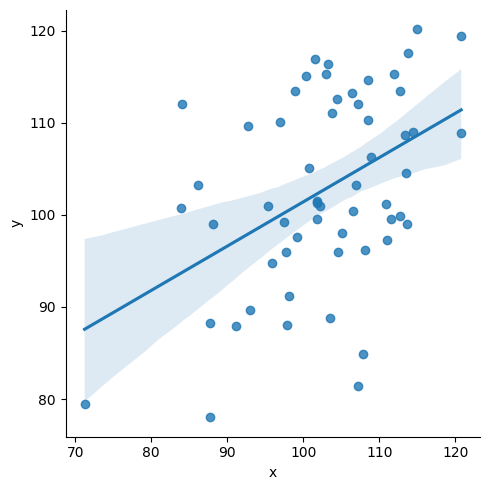

In [40]:
plot_correlation(M_MZ2)

PearsonRResult(statistic=0.43593277484565124, pvalue=4.7448760529686195e-05)


/home/jc225751/Runs/61_classifier_regresser/Program/venv_natif/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


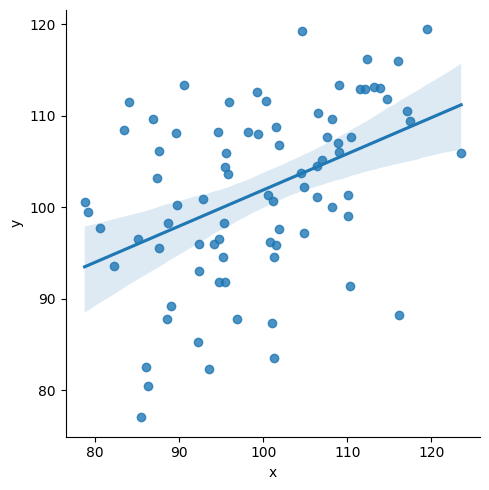

In [41]:
plot_correlation(F_MZ2)

PearsonRResult(statistic=-0.22612174863077483, pvalue=0.22954493012848254)


/home/jc225751/Runs/61_classifier_regresser/Program/venv_natif/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


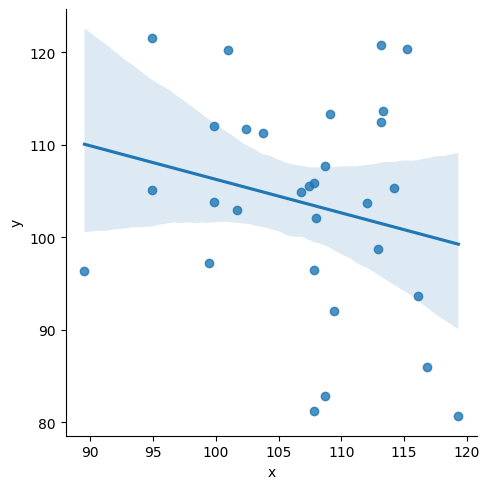

In [42]:
plot_correlation(M_DZ2)

PearsonRResult(statistic=-0.050862391444666345, pvalue=0.72853848375605)


/home/jc225751/Runs/61_classifier_regresser/Program/venv_natif/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


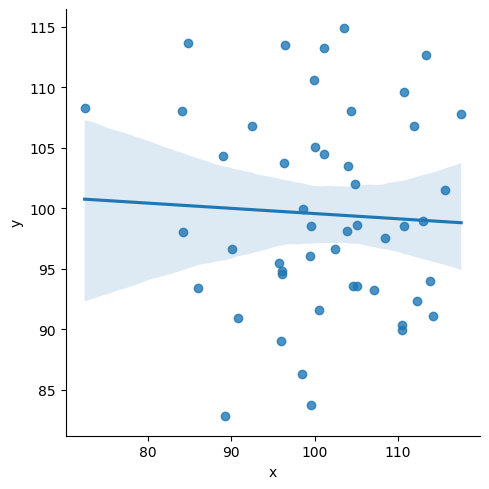

In [43]:
plot_correlation(F_DZ2)

# Keeps extreme Flanker

In [44]:
len(participants)

1113

In [45]:
participants.head()

,Subject,Gender,Flanker_AgeAdj,ZygosityGT,Family_ID
1,100206,M,116.55,NotTwin,56037_85858
2,100307,F,101.90,MZ,51488_81352
3,100408,M,113.51,MZ,51730_81594
4,100610,M,114.18,DZ,52813_82634
5,101006,F,92.33,NotTwin,51283_52850_81149


In [46]:
q_33 = participants['Flanker_AgeAdj'].quantile(q=0.33)
q_66 = participants['Flanker_AgeAdj'].quantile(q=0.66)
print(f"quantile 0.33: {q_33}; quantile 0.66: {q_66}")

quantile 0.33: 97.5692; quantile 0.66: 106.9092


In [47]:
participants_extreme = participants[(participants.Flanker_AgeAdj < q_33) | (participants.Flanker_AgeAdj > q_66)]

In [48]:
eM_MZ = create_subset(participants_extreme, 'M', 'MZ')
eF_MZ = create_subset(participants_extreme, 'F', 'MZ')
eM_DZ = create_subset(participants_extreme, 'M', 'DZ')
eF_DZ = create_subset(participants_extreme, 'F', 'DZ')
eM_NotTwin = create_subset(participants_extreme, 'M', 'NotTwin')
eF_NotTwin = create_subset(participants_extreme, 'F', 'NotTwin')
eM_MZ.head()

Subject Gender  Flanker_AgeAdj ZygosityGT    Family_ID
0 632   233326      M          114.95         MZ  51698_81562
  719   352738      M          120.15         MZ  51698_81562
1 253   146432      M          108.16         MZ  51702_81566
  1077  818859      M           96.24         MZ  51702_81566
2 155   128935      M          108.56         MZ  51707_81571

# Stratify

In [49]:
partition = [0.7,0.15,0.15]

In [50]:
def get_train(df, partition):
    df = df.copy(deep=True)
    upper = int(len(df)*partition[0]/2)*2
    return df[0:upper]

def get_val(df, partition):
    df = df.copy(deep=True)
    lower = int(len(df)*partition[0]/2)*2
    upper = int(len(df)*(partition[0]+partition[1])/2)*2
    return df[lower:upper]

def get_test(df, partition):
    df = df.copy(deep=True)
    lower = int(len(df)*(partition[0]+partition[1])/2)*2
    return df[lower:]


In [52]:
participants_extreme.dtypes

Subject           string[python]
Gender                    object
Flanker_AgeAdj           float64
ZygosityGT                object
Family_ID                 object
dtype: object

In [53]:
def partition_subset(df, partition):
    train = get_train(df, partition)
    val = get_val(df, partition)
    test = get_test(df, partition)
    print(f"lengths: {len(df)} = {len(train) + len(val) + len(test)} = {len(train)} + {len(val)} + {len(test)}")
    return train, val, test

In [54]:
def put_together(df, partition, alls):
    train, val, test = partition_subset(df, partition)
    alls['train'] = pd.concat([alls['train'], train], ignore_index=True)
    alls['val']   = pd.concat([alls['val'], val], ignore_index=True)
    alls['test']  = pd.concat([alls['test'], test], ignore_index=True)
    return alls

In [55]:
alls = {}
alls['train'] = pd.DataFrame(columns=participants.columns).astype(participants.dtypes.to_dict())
alls['val']   = val = pd.DataFrame(columns=participants.columns).astype(participants.dtypes.to_dict())
alls['test']  = pd.DataFrame(columns=participants.columns).astype(participants.dtypes.to_dict())



In [56]:
alls = put_together(eM_MZ, partition, alls)
alls = put_together(eF_MZ, partition, alls)
alls = put_together(eM_DZ, partition, alls)
alls = put_together(eF_DZ, partition, alls)
alls = put_together(eM_NotTwin, partition, alls)
alls = put_together(eF_NotTwin, partition, alls)
alls['train_val'] = pd.concat([alls['train'], alls['val']], ignore_index=True)

lengths: 77 = 77 = 52 + 12 + 13
lengths: 117 = 117 = 80 + 18 + 19
lengths: 44 = 44 = 30 + 6 + 8
lengths: 70 = 70 = 48 + 10 + 12
lengths: 226 = 226 = 158 + 34 + 34
lengths: 212 = 212 = 148 + 32 + 32


In [57]:
alls['test'][alls['test'].Gender == "F"]

,Subject,Gender,Flanker_AgeAdj,ZygosityGT,Family_ID
13,146735,F,91.81,MZ,55646_85468
14,263436,F,78.74,MZ,55651_85473
15,200008,F,107.58,MZ,55686_85508
16,767464,F,107.67,MZ,55686_85508
17,933253,F,112.66,MZ,55697_85519
...,...,...,...,...,...
113,128026,F,97.24,NotTwin,56150_85970
114,481042,F,82.48,NotTwin,56166_85985
115,828862,F,92.69,NotTwin,56171_85990
116,809252,F,114.29,NotTwin,56183_86002


In [58]:

len(alls['train']) + len(alls['val']) + len(alls['test'])

746

In [59]:
len(alls['train_val'])

628

In [60]:
len(alls['val'])

112

In [61]:
len(alls['test'])

118

In [62]:
output_dir = "/neurospin/dico/data/deep_folding/current/datasets/hcp-top-separated/"
train_file = f"{output_dir}extreme_flanker_train_subjects.csv"
val_file = f"{output_dir}extreme_flanker_val_subjects.csv"
test_file = f"{output_dir}extreme_flanker_test_subjects.csv"
alls['train']['Subject'].to_csv(train_file, index=False, header=False)
alls['val']['Subject'].to_csv(val_file, index=False, header=False)
alls['test']['Subject'].to_csv(test_file, index=False, header=False)

In [63]:
!more {train_file} | wc -l

516


In [64]:
!more {val_file} | wc -l

112


In [65]:
!more {test_file} | wc -l

118
